In [82]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [83]:
model_path = "ckpts/sft_triviaqa_llama7B/checkpoint_20000/hf_model/"

sft_answer_log_probs_mean_all = np.load(os.path.join(model_path, "test_answer_log_probs_mean_all.npy"))

sft_answers_correct = np.load(os.path.join(model_path, "test_answers_correct.npy"))


In [84]:
np.mean(sft_answers_correct)

0.6640102541239411

(array([2.0000e+00, 2.0000e+00, 0.0000e+00, 1.2000e+01, 5.1000e+01,
        2.2300e+02, 5.7000e+02, 1.4730e+03, 4.1160e+03, 1.1495e+04]),
 array([-1.16655135e+00, -1.04991640e+00, -9.33281444e-01, -8.16646490e-01,
        -7.00011536e-01, -5.83376582e-01, -4.66741628e-01, -3.50106674e-01,
        -2.33471720e-01, -1.16836766e-01, -2.01811694e-04]),
 <BarContainer object of 10 artists>)

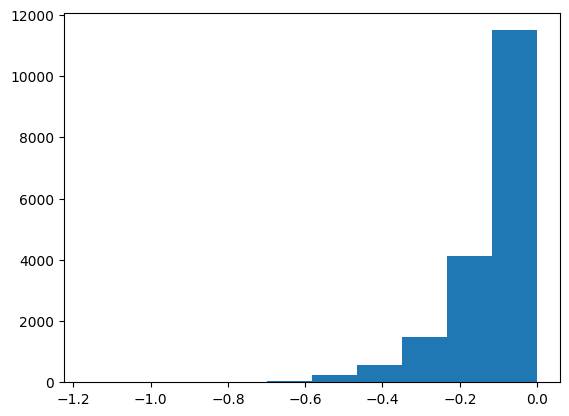

In [85]:
plt.hist(sft_answer_log_probs_mean_all)

In [86]:
percentiles = [0, 20, 40, 60, 80, 100]
nll_bins = np.percentile(-sft_answer_log_probs_mean_all, percentiles)

In [87]:
accuracies = []

for i in range(len(nll_bins) - 1):
    bin_lower = nll_bins[i]
    bin_upper = nll_bins[i + 1]

    indices = np.where((-sft_answer_log_probs_mean_all >= bin_lower) & (-sft_answer_log_probs_mean_all < bin_upper))[0]

    accuracies.append(np.mean(sft_answers_correct[indices]))

In [88]:
accuracies

[0.9646140986347171,
 0.8971858456394539,
 0.7603121516164995,
 0.5284280936454849,
 0.16968514906659238]

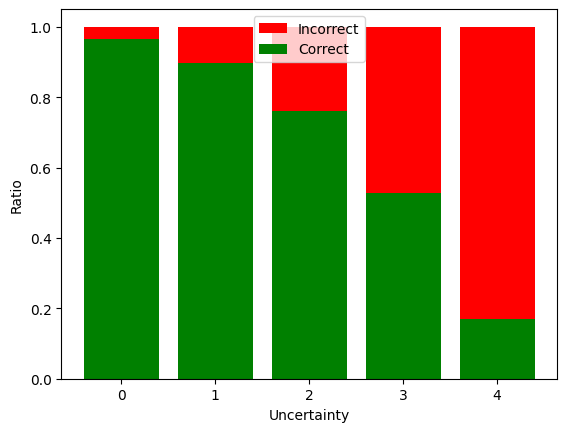

In [89]:
plt.bar([0, 1, 2, 3, 4], [1, 1, 1, 1, 1], color="red", label = "Incorrect")
plt.bar([0, 1, 2, 3, 4], accuracies, color="green", label = "Correct")

plt.xlabel("Uncertainty")
plt.ylabel("Ratio")
plt.legend()

In [75]:
model_path = "ckpts/sft2_triviaqa_llama7B_t0.9/checkpoint_20000/hf_model/"

sft2_answers_correct = np.load(os.path.join(model_path, "test_answers_correct.npy"))
sft2_answers_dont_know = np.load(os.path.join(model_path, "test_answers_dont_know.npy"))

In [76]:
sft2_answers_correct

idxs = np.where(sft2_answers_dont_know == 0)[0]
sft2_answers_correct[idxs].mean()

# (1- sft2_answers_dont_know - sft2_answers_correct).mean()

0.7961437663796331

In [77]:
(1- sft_answers_correct).mean()

0.33598974587605884

In [78]:
accuracies = []
dont_know_frac = []

for i in range(len(nll_bins) - 1):
    bin_lower = nll_bins[i]
    bin_upper = nll_bins[i + 1]

    indices = np.where((-sft_answer_log_probs_mean_all >= bin_lower) & (-sft_answer_log_probs_mean_all < bin_upper))[0]

    accuracies.append(np.mean(sft2_answers_correct[indices]))
    dont_know_frac.append(np.mean(sft2_answers_dont_know[indices]))

accuracies = np.array(accuracies)
dont_know_frac = np.array(dont_know_frac)
selective_accuracies = accuracies/(1-np.array(dont_know_frac))

In [79]:
accuracies/(1-np.array(dont_know_frac))

array([0.96206897, 0.90084388, 0.77423364, 0.54494382, 0.20977918])

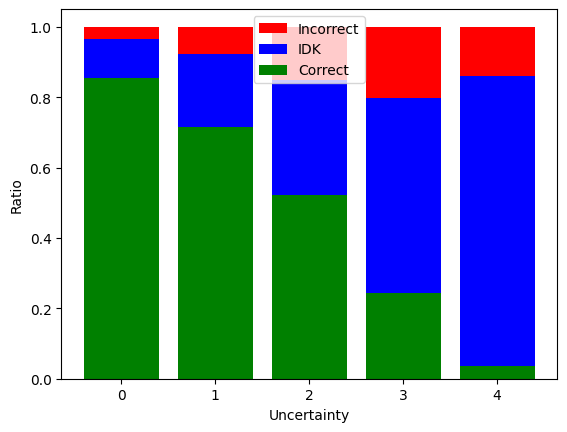

In [80]:
plt.bar([0, 1, 2, 3, 4], [1, 1, 1, 1, 1], color="red", label="Incorrect")
plt.bar([0, 1, 2, 3, 4], accuracies+dont_know_frac, color="blue", label="IDK")

plt.bar([0, 1, 2, 3, 4], accuracies, color="green", label="Correct")
plt.xlabel("Uncertainty")
plt.ylabel("Ratio")

plt.legend()



In [81]:
accuracies

array([0.85511284, 0.71384787, 0.52090301, 0.24331104, 0.03705768])

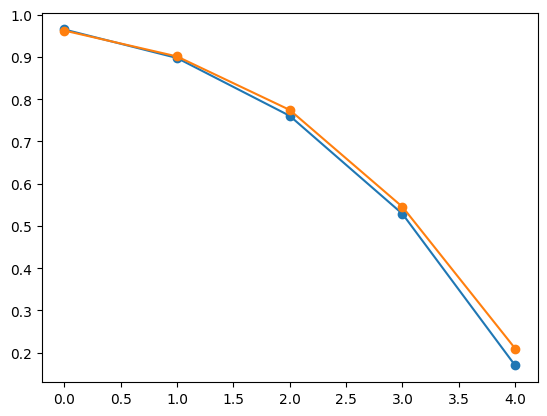

In [74]:



plt.plot(accuracies, "o-")

plt.plot(selective_accuracies, "o-")